# PROJET DEEP LEARNING

## IMPORTATION DES MODULES

In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision
import numpy as np

## PRE-TRAITEMENT DES DONNEES

In [2]:
print('total training damage images: ',len(os.listdir("./train_another/damage")))
print('total validation damage images: ',len(os.listdir("./validation_another/damage")))
print('total test damage images: ',len(os.listdir("./test_another/damage")))
print('total training no damage images: ',len(os.listdir("./train_another/no_damage")))
print('total validation no damage images: ',len(os.listdir("./validation_another/no_damage")))
print('total test no damage images: ',len(os.listdir("./test_another/no_damage")))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  8000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


### Importation des images en séparant en jeu train / test / validation

In [2]:
transform = transforms.Compose([transforms.Resize((150,150)),
                                 transforms.ToTensor()])
batch_size = 20

df_train = datasets.ImageFolder("./train_another",transform=transform)
train_dataloader = DataLoader(dataset=df_train, batch_size=batch_size, shuffle=True, num_workers = 4 , pin_memory = True)

df_test = datasets.ImageFolder("./test_another",transform=transform)
test_dataloader = DataLoader(dataset=df_test, batch_size=batch_size, shuffle=True,num_workers = 4 , pin_memory = True)

df_validation = datasets.ImageFolder("./validation_another",transform=transform)
validation_dataloader = DataLoader(dataset=df_validation, batch_size=batch_size, shuffle=True,num_workers = 4 , pin_memory = True)

Essayons de visualiser les classes de nos images 

In [5]:
df_validation.classes

['damage', 'no_damage']

## MODELISATION

### MODELE 1 : Reproduction du modèle de CAO & CHOE

#### Création de la classe qui va nous permettre de faire notre classification d'images

In [3]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

#### Création de la classe qui va permettre de créer notre premier modèle

In [6]:
class HurricaneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3,32, kernel_size = (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64, kernel_size = (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,128, kernel_size = (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(6272, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.ReLU(),
        )
    
    def forward(self, xb):
        return self.network(xb)

#### Création des fonctions qui vont permettre d'évaluer notre modèle

In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    nb_etape = 0
    outputs = []
    for batch in val_loader:
        nb_etape = nb_etape + 1
        outputs.append(model.validation_step(batch))
        if nb_etape == 50:
            break
            
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        nb_etape = 0
        
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            nb_etape = nb_etape+1
            if nb_etape == 100:
                break
                
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history, train_losses

Fonction pour calculer la précision sur le jeu de données validation

In [5]:
def val_CNN(net, valLoader):
    correct, total = 0, 0
    predictions = []
    net.eval()
    for i, data in enumerate(valLoader, 0):
        inputs, labels = data
        outputs = net(inputs)    
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('The testing set accuracy of the network is: %d %%' % (100 * correct / total))

Instanciation du modèle

In [22]:
model = HurricaneClassification()
num_epochs = 50
opt_func = torch.optim.Adam
lr = 1e-4
#fitting the model on training data and record the result after each epoch
history, loss = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_func)

Epoch [0], train_loss: 0.6821, val_loss: 0.6515, val_acc: 0.5650
Epoch [1], train_loss: 0.6334, val_loss: 0.5907, val_acc: 0.8250
Epoch [2], train_loss: 0.5575, val_loss: 0.6227, val_acc: 0.7550
Epoch [3], train_loss: 0.5333, val_loss: 0.5010, val_acc: 0.8580
Epoch [4], train_loss: 0.5103, val_loss: 0.4826, val_acc: 0.8700
Epoch [5], train_loss: 0.5146, val_loss: 0.5591, val_acc: 0.8220
Epoch [6], train_loss: 0.4572, val_loss: 0.4724, val_acc: 0.8850
Epoch [7], train_loss: 0.4917, val_loss: 0.4612, val_acc: 0.8740
Epoch [8], train_loss: 0.4732, val_loss: 0.4577, val_acc: 0.8810
Epoch [9], train_loss: 0.4659, val_loss: 0.4786, val_acc: 0.8850
Epoch [10], train_loss: 0.4610, val_loss: 0.4379, val_acc: 0.9030
Epoch [11], train_loss: 0.4699, val_loss: 0.4426, val_acc: 0.8940
Epoch [12], train_loss: 0.4499, val_loss: 0.4408, val_acc: 0.8970
Epoch [13], train_loss: 0.4513, val_loss: 0.4420, val_acc: 0.9070
Epoch [14], train_loss: 0.4375, val_loss: 0.4525, val_acc: 0.9000
Epoch [15], train_lo

In [62]:
summary(model,(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
              ReLU-2         [-1, 32, 148, 148]               0
         MaxPool2d-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 72, 72]          18,496
              ReLU-5           [-1, 64, 72, 72]               0
         MaxPool2d-6           [-1, 64, 36, 36]               0
            Conv2d-7          [-1, 128, 34, 34]          73,856
              ReLU-8          [-1, 128, 34, 34]               0
         MaxPool2d-9          [-1, 128, 17, 17]               0
           Conv2d-10          [-1, 128, 15, 15]         147,584
             ReLU-11          [-1, 128, 15, 15]               0
        MaxPool2d-12            [-1, 128, 7, 7]               0
          Flatten-13                 [-1, 6272]               0
          Dropout-14                 [-

#### Sauvegarde du modèle

In [ ]:
torch.save(model.state_dict(),"model1")

On crée également un sauvegarde de la variable loss pour éviter de la recharger en cas de crash à cause de matplotlib

In [64]:
import pickle

# sauvegarde
with open("loss1","wb") as f:
    pickle.dump(loss,f)





In [65]:
# chargement
with open("loss1","rb") as f:
    loss_loaded = pickle.load(f)

Le code pour l'affichage du plot est en commentaire car il arrive que matplotlib tue notre kernel

In [66]:
loss_tensor = torch.stack(loss_loaded)
loss_np=torch.detach(loss_tensor).numpy()

#plt.plot(loss)
#plt.xlabel('Itération')
#plt.ylabel('Perte')
#plt.show()

[tensor(0.4509, requires_grad=True), tensor(0.3548, requires_grad=True), tensor(0.5223, requires_grad=True), tensor(0.4511, requires_grad=True), tensor(0.3464, requires_grad=True), tensor(0.2550, requires_grad=True), tensor(0.5251, requires_grad=True), tensor(0.3134, requires_grad=True), tensor(0.3033, requires_grad=True), tensor(0.3829, requires_grad=True), tensor(0.3678, requires_grad=True), tensor(0.4022, requires_grad=True), tensor(0.2800, requires_grad=True), tensor(0.4875, requires_grad=True), tensor(0.2494, requires_grad=True), tensor(0.3815, requires_grad=True), tensor(0.4023, requires_grad=True), tensor(0.4261, requires_grad=True), tensor(0.3152, requires_grad=True), tensor(0.3257, requires_grad=True), tensor(0.6313, requires_grad=True), tensor(0.3922, requires_grad=True), tensor(0.3583, requires_grad=True), tensor(0.3142, requires_grad=True), tensor(0.5271, requires_grad=True), tensor(0.4069, requires_grad=True), tensor(0.3888, requires_grad=True), tensor(0.4729, requires_gra

In [67]:
val_model1 = acc_val(model,validation_dataloader)

The accuracy of the network on the validation images is: 92 %


### MODELE 2 : Fine tuning VGG-19

In [14]:
model2 = torchvision.models.vgg19(pretrained=True)
print(model2)

c:\Users\spica\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\spica\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
num_classes = 1000

# Verrouillage des couches du modèle (sauf la dernière) pour éviter leur mise à jour lors de l'entraînement
for param in model2.parameters():
    param.requires_grad = False

# Modification du nombre de classes en sortie (par défaut 1000) si nécessaire
model2.classifier[6] = torch.nn.Linear(in_features=4096, out_features=num_classes)

# Déverrouillage de la dernière couche pour permettre son entraînement
for param in model2.classifier[6].parameters():
    param.requires_grad = True

# Conversion en mode "entraînement"
model2.train()

# Préparation des transformateurs pour les données d'entraînement
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

batch_size = 20
num_epochs = 20

trainset = torchvision.datasets.ImageFolder(root='./train_another', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
loss_values = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        # Chargement des entrées et des étiquettes
        inputs, labels = data
        
        # Calcul des sorties à l'aide de la méthode forward
        outputs = model2(inputs)
        
        # Calcul de la perte
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        
        # Ajout de la perte à la liste
        loss_values.append(loss.item())
        # Calcul des gradients pour la rétropropagation
        optimizer = torch.optim.SGD(model2.classifier[6].parameters(), lr=0.001, momentum=0.9)
        optimizer.zero_grad()
        loss.backward()
        
        # Mise à jour des paramètres du modèle
        optimizer.step()
        
        # Affichage de la progression de l'entraînement toutes les 100 itérations
        if i ==100:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            break

[1,   101] loss: 0.561
[2,   101] loss: 0.459
[3,   101] loss: 0.430
[4,   101] loss: 0.278
[5,   101] loss: 0.406
[6,   101] loss: 0.122
[7,   101] loss: 0.421
[8,   101] loss: 0.447
[9,   101] loss: 0.280
[10,   101] loss: 0.244
[11,   101] loss: 0.341
[12,   101] loss: 0.464
[13,   101] loss: 0.166
[14,   101] loss: 0.304
[15,   101] loss: 0.228
[16,   101] loss: 0.271
[17,   101] loss: 0.373
[18,   101] loss: 0.301
[19,   101] loss: 0.225
[20,   101] loss: 0.398


On sauvegarde le modèle

In [16]:
torch.save(model2.state_dict(),"model2")

In [41]:
import pickle

# sauvegarde
with open("loss_vgg19", "wb") as f:
    pickle.dump(loss_values, f)
    
# chargement
with open("loss_vgg19", "rb") as f:
    loss2_loaded = pickle.load(f)

#### Courbe de gain

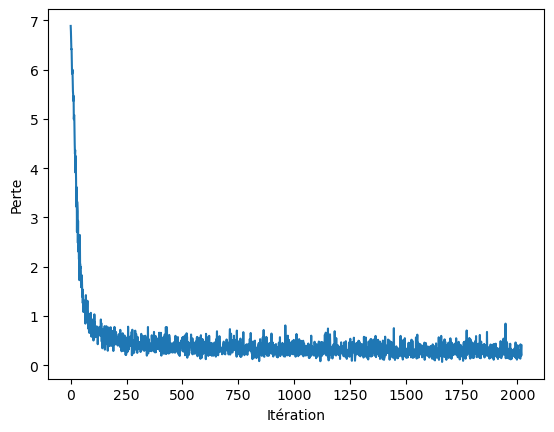

In [43]:
plt.plot(loss2_loaded)
plt.xlabel('Itération')
plt.ylabel('Perte')
plt.show()

In [44]:
val_model2 = val_CNN(model2,validation_dataloader)

The testing set accuracy of the network is: 50 %


## Modèle 3 : Création de notre propre CNN

In [6]:
class NotreModeleClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3,32, kernel_size = (3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64, kernel_size = (3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = (3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,128, kernel_size = (3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 2),
            nn.LeakyReLU(),
        )
    
    def forward(self, xb):
        return self.network(xb)

### MODELES DE MACHINE LEARNING

#### Extraction des features du modèles

In [25]:
def extract_features(dataloader, model, n_sample, n_features):
    features = np.zeros(shape=(n_sample,n_features))
    batchSize = dataloader.batch_size
    labels = np.zeros(shape = (n_sample))
    i = 0
    for inputs_batch, labels_batch in dataloader:
        model.eval()
        features_batch = model(inputs_batch).detach().numpy()
        features[i * batchSize: (i + 1) * batchSize] = features_batch
        labels[i * batchSize: (i + 1) * batchSize] = labels_batch
        i += 1
        if i * batchSize >= n_sample:
            break
    return features, labels

On regarde les outputs de notre modèle

In [ ]:
summary(model, (3,150,150))

In [27]:
x_train, y_train = extract_features(train_dataloader,model,10000,2)
x_test, y_test = extract_features(validation_dataloader, model, 2000, 2)


In [43]:
best_model = ""
best_acc = 0

#### Modèle 1 : Arbres de décisions

In [44]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)

DecisionTreeClassifier()

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix 
y_pred = clf.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print("Précision : " + str(accuracy_score(y_test,y_pred)))

if accuracy_score(y_test,y_pred)>best_acc:
    best_model = clf
    best_acc = accuracy_score(y_test,y_pred)

[[875 125]
 [150 850]]
Précision : 0.8625
DecisionTreeClassifier()


#### Modèle 2 : Fôrets aléatoires + GridSearch

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth' : np.arange(start = 10, stop = 21, step = 1) , 
              'min_samples_leaf' : np.arange(start = 2, stop = 4, step = 1),
              'min_samples_split' : np.arange(start = 2, stop = 4, step = 1)}

clf2 = RandomForestClassifier()
clf2 = GridSearchCV(clf2,parameters,scoring="accuracy",verbose=2,cv=5)
clf2.fit(x_train,y_train)

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=2; total time=   0.4s
[CV] END max_depth=10, mi

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                         'min_samples_leaf': array([2, 3]),
                         'min_samples_split': array([2, 3])},
             scoring='accuracy', verbose=2)

In [48]:
y_pred = clf2.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print("Précision : " + str(accuracy_score(y_test,y_pred)))

if accuracy_score(y_test,y_pred)>best_acc:
    best_model = clf2
    best_acc = accuracy_score(y_test,y_pred)

[[934  66]
 [117 883]]
Précision : 0.9085


#### Modèles 3 : AdaBoost

In [49]:
from sklearn.ensemble import AdaBoostClassifier
clf3 = AdaBoostClassifier()
clf3.fit(x_train,y_train)

AdaBoostClassifier()

In [50]:
y_pred = clf3.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print("Précision : " + str(accuracy_score(y_test,y_pred)))

if accuracy_score(y_test,y_pred)>best_acc:
    best_model = clf3
    best_acc = accuracy_score(y_test,y_pred)

[[932  68]
 [120 880]]
Précision : 0.906


#### Modèle 4 : Lightgbm

In [51]:
import lightgbm as lgb
clf4 = lgb.LGBMClassifier()
clf4.fit(x_train,y_train)

LGBMClassifier()

In [52]:
y_pred = clf4.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print("Précision : " + str(accuracy_score(y_test,y_pred)))

if accuracy_score(y_test,y_pred)>best_acc:
    best_model = clf4
    best_acc = accuracy_score(y_test,y_pred)

[[928  72]
 [112 888]]
Précision : 0.908


#### Modèle 5 : Bagging

In [53]:
from sklearn.ensemble import BaggingClassifier
clf5 = BaggingClassifier()
clf5.fit(x_train,y_train)

BaggingClassifier()

In [54]:
y_pred = clf5.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print("Précision : " + str(accuracy_score(y_test,y_pred)))

if accuracy_score(y_test,y_pred)>best_acc:
    best_model = clf5
    best_acc = accuracy_score(y_test,y_pred)

[[914  86]
 [142 858]]
Précision : 0.886


In [55]:
print(best_model)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                         'min_samples_leaf': array([2, 3]),
                         'min_samples_split': array([2, 3])},
             scoring='accuracy', verbose=2)


#### Conclusion

Notre meilleur modèle est :

In [60]:
print("Notre meilleur modèle est : "+str(best_model))
print("avec une précision de "+ str(best_acc))

Notre meilleur modèle est : GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                         'min_samples_leaf': array([2, 3]),
                         'min_samples_split': array([2, 3])},
             scoring='accuracy', verbose=2)
avec une précision de 0.9085
